In [1]:
import sklearn
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import lib.compressions as compressions
from lib.functions import LogisticRegression
import lib.load_datasets as load_datasets

In [23]:
X, y = load_datasets.dataset_to_X_y('diabetes.csv', nrows=100)
#X, y = make_blobs(n_samples=10, centers=2, n_features=8, random_state=0)
function = LogisticRegression(X, y)

In [24]:
experiments = [
    compressions.compressedGD(function, name='Without'),
    compressions.compressedGD(function, compression=compressions.topK, k=function.get_dimention()//3, name='Top-k, k=d/3'),
    compressions.compressedGD(function, compression=compressions.topK, k=1, name='Top-k, k=1'),
    compressions.compressedGD(function, compression=compressions.uniformCompression, name='Rand-k, k=d/2'),
    #compressions.compressedGD(function, compression=compressions.uniformCompression, k=1, name=r'Rand-k, k=1'),
    compressions.stochasticCompressedGD(function, compression=compressions.stochasticCompression, k=function.get_dimention()//3, name='Stochastic, k=d/3'),
]

experiments.sort(key=lambda exp : exp['k'] * exp['num_iter'])

table = [
    ["compression", "num_iter", "transmitted coordinates"],
    *[
        [exp['name'], exp['num_iter'], exp['k'] * exp['num_iter']]
        for exp in experiments
    ]
]
print(tabulate(table))

/Users/ndshaposhnik/Documents/compressionGraphics/lib/functions.py:6: RuntimeWarning: overflow encountered in exp
  sigma = lambda x : 1 / (1 + np.exp(-x))


end Stochastic, k=d/3
-----------------  --------  -----------------------
compression        num_iter  transmitted coordinates
Top-k, k=1         1000000   1000000
Top-k, k=d/3       1000000   3000000
Stochastic, k=d/3  1000000   3000000
Rand-k, k=d/2      1000000   4000000
Without            1000000   9000000
-----------------  --------  -----------------------


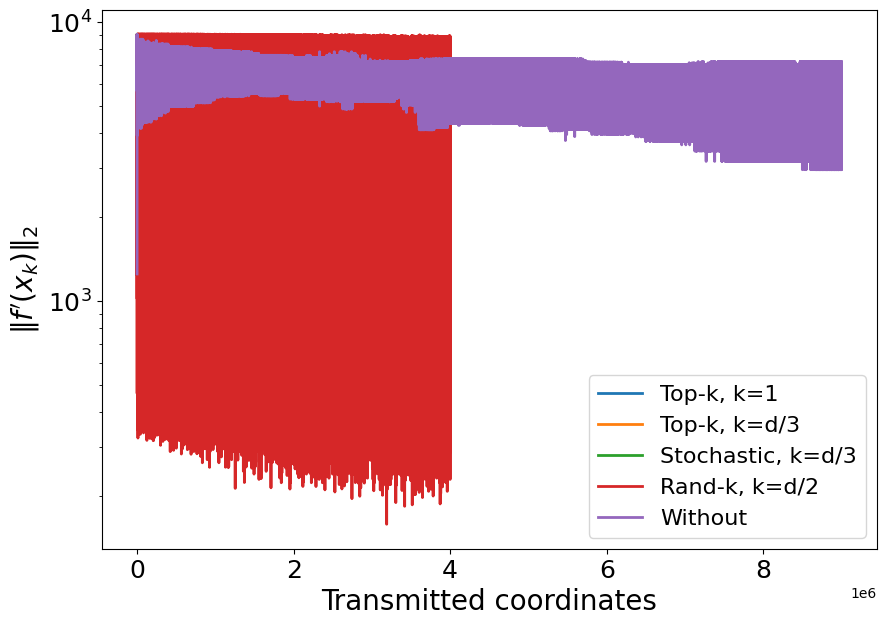

In [25]:
plt.figure(figsize=(10, 7))
for exp in experiments:
    plt.semilogy(
        exp['coords'],
        [grad_norm for grad_norm in exp['gradients']],
        label=exp['name'],
        linewidth=2
    )
plt.legend(loc="best", fontsize=16)
plt.xlabel(r"Transmitted coordinates", fontsize=20)
plt.ylabel(r"$\|f'(x_k)\|_2$", fontsize=20)
plt.xticks(fontsize=18)
_ = plt.yticks(fontsize=18)